# Initial Analysis of Full WSDOT Data

In [3]:
library(tidyverse)
library(RSQLCipher)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [16]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))

db_path = "../../../db/hot.db"

## Census Data

In [17]:
census = load_table(db_path, "census")

In [18]:
# creates full census table
census_test = census %>%
  execute
  
head(census_test)

id,is_plate,city,state,zip_code,is_exact,fips,county,cty_subdivision,block
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-9.223315e+18,1,NEWCASTLE,WA,98059,1,530330250051,33,25005,1031
-9.223232e+18,1,COVINGTON,WA,98042,1,530330320051,33,32005,1030
-9.223196e+18,1,BRIER,WA,98036,1,530610519134,61,51913,4000
-9.223132e+18,0,LYNNWOOD,WA,98036,1,530610515002,61,51500,2007
-9.223037e+18,0,REDMOND,WA,98053,1,530330323272,33,32327,2012
-9.222993e+18,0,RENTON,WA,98059,1,530330251023,33,25102,3005


#### About 45 percent of census records are plates and 82 percent of all trips are "exact" matches through geocoding

In [19]:
# finds amount of plates and exact geocodes in census matching data
census_test %>%
    summarize(mean(is_plate),
             mean(is_exact))

mean(is_plate),mean(is_exact)
<dbl>,<dbl>
0.4515402,0.8224085


In [20]:
# read in ACS estimates
census_estimates <- read.csv(file = "../../../dssg-hot/data/block_group_census_estimates_wide.csv")
census_estimates <- census_estimates %>% 
    rename(fips = fips_code)
head(census_estimates)
head(census_test)

fips,county_name,county,tract,block_group,inc_000_035k,inc_035_050k,inc_050_075k,inc_075_100k,inc_100_125k,⋯,inc_150_200k,inc_200_infk,med_age,med_inc,population,race_nonhisp_asian,race_nonhisp_white,trans_carpool,trans_drivealone,trans_transit
<dbl>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.3033e+11,King,33,100,1,0.1776316,0.02467105,0.06578947,0.15296053,0.10361842,⋯,0.152960526,0.30098684,54.0,118026,1265,0.07667984,0.8774704,0.10102489,0.6105417,0.1200586
5.3033e+11,King,33,100,2,0.2796834,0.25461741,0.17941953,0.13192612,0.08839050,⋯,0.007915567,0.02110818,37.0,46645,1534,0.07692308,0.5013038,0.07573633,0.6072931,0.2342216
5.3033e+11,King,33,100,3,0.3853591,0.04143646,0.15883978,0.12983425,0.11602210,⋯,0.095303867,0.04972376,36.4,63000,1817,0.13538800,0.5976885,0.10266160,0.5674905,0.2452471
5.3033e+11,King,33,100,4,0.4914449,0.15399240,0.15494297,0.11121673,0.07414449,⋯,0.000000000,0.00000000,29.3,35271,2270,0.14052863,0.2854626,0.11237113,0.5381443,0.2319588
5.3033e+11,King,33,100,5,0.4788069,0.10518053,0.18053375,0.08948195,0.02197802,⋯,0.072213501,0.02354788,34.4,36250,1077,0.24698236,0.6350975,0.28549383,0.3935185,0.1774691
5.3033e+11,King,33,200,1,0.0000000,0.10275229,0.28623853,0.22935780,0.24220183,⋯,0.086238532,0.00000000,44.2,85391,1183,0.07438715,0.7032967,0.09530387,0.5566298,0.1174033


id,is_plate,city,state,zip_code,is_exact,fips,county,cty_subdivision,block
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-9.223315e+18,1,NEWCASTLE,WA,98059,1,530330250051,33,25005,1031
-9.223232e+18,1,COVINGTON,WA,98042,1,530330320051,33,32005,1030
-9.223196e+18,1,BRIER,WA,98036,1,530610519134,61,51913,4000
-9.223132e+18,0,LYNNWOOD,WA,98036,1,530610515002,61,51500,2007
-9.223037e+18,0,REDMOND,WA,98053,1,530330323272,33,32327,2012
-9.222993e+18,0,RENTON,WA,98059,1,530330251023,33,25102,3005


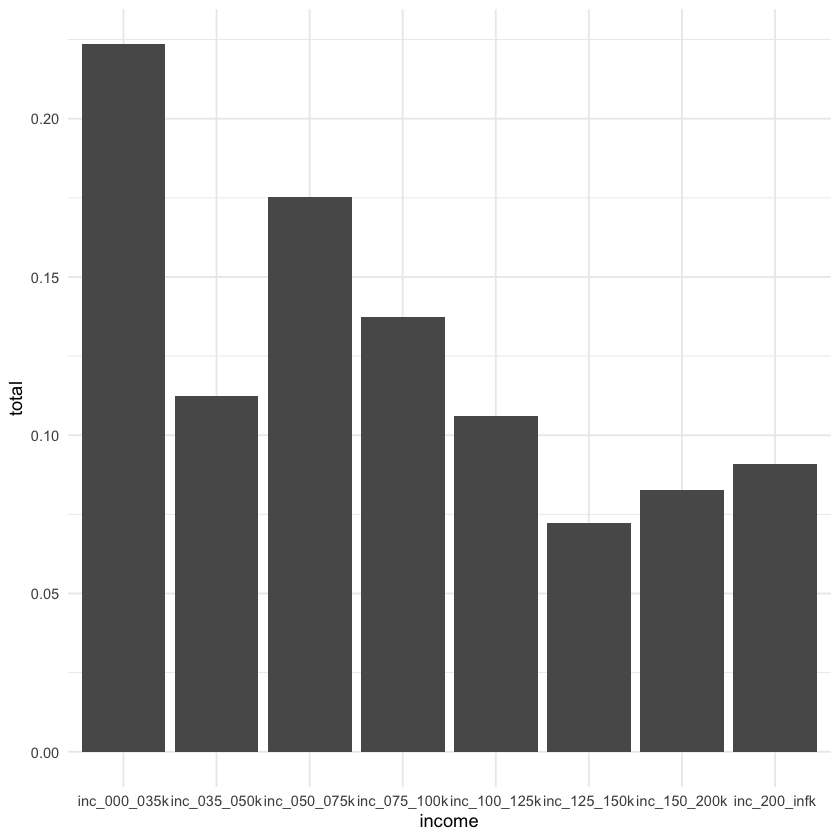

In [21]:
census_estimates %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    gather(income, total, inc_000_035k:inc_200_infk) %>%
ggplot(aes(x = income, y = total)) +
    geom_bar(stat = "identity") +
    theme_minimal()

In [22]:
# merge census test with census estimates
census_merge <- merge(x = census_test, y = census_estimates, by = "fips", all = FALSE)
colnames(census_merge)
head(census_merge)

[1] "fips"               "id"                 "is_plate"          
 [4] "city"               "state"              "zip_code"          
 [7] "is_exact"           "county.x"           "cty_subdivision"   
[10] "block"              "county_name"        "county.y"          
[13] "tract"              "block_group"        "inc_000_035k"      
[16] "inc_035_050k"       "inc_050_075k"       "inc_075_100k"      
[19] "inc_100_125k"       "inc_125_150k"       "inc_150_200k"      
[22] "inc_200_infk"       "med_age"            "med_inc"           
[25] "population"         "race_nonhisp_asian" "race_nonhisp_white"
[28] "trans_carpool"      "trans_drivealone"   "trans_transit"

fips,id,is_plate,city,state,zip_code,is_exact,county.x,cty_subdivision,block,⋯,inc_150_200k,inc_200_infk,med_age,med_inc,population,race_nonhisp_asian,race_nonhisp_white,trans_carpool,trans_drivealone,trans_transit
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.3033e+11,5.718314e+18,0,SEATTLE,WA,98125,1,33,100,1015,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
5.3033e+11,5.637426e+17,1,SEATTLE,WA,98125,1,33,100,1018,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
5.3033e+11,1.641750e+18,0,SEATTLE,WA,98125,1,33,100,1016,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
5.3033e+11,8.994807e+18,0,SEATTLE,WA,98125,1,33,100,1015,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
5.3033e+11,6.176229e+18,0,SEATTLE,WA,98125,1,33,100,1015,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
5.3033e+11,4.553375e+18,1,SEATTLE,WA,98125,1,33,100,1021,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586


Warning message in summarise_impl(.data, dots, environment(), caller_env()):
“integer overflow - use sum(as.numeric(.))”

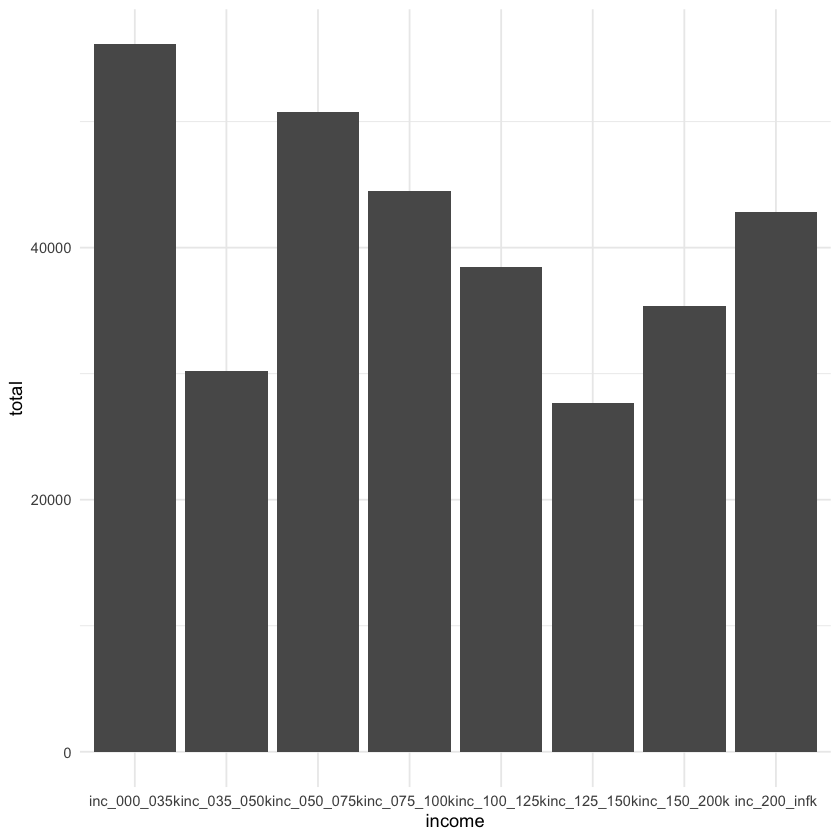

In [23]:
census_merge %>%
    summarize_at(vars(contains("inc")), sum, na.rm=T) %>%
    gather(income, total, inc_000_035k:inc_200_infk) %>%
ggplot(aes(x = income, y = total)) +
    geom_bar(stat = "identity") +
    theme_minimal()

### The next few analyses demonstrate census data related to usage across the corrdior without regard to frequency

In [8]:
# summarizes mean white population and asian population
census_merge %>%
    summarize(mean_asian = mean(race_nonhisp_asian),
              mean_white = mean(race_nonhisp_white))

mean_asian,mean_white
<dbl>,<dbl>
0.1383044,0.6805716


#### Median Income Distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3523 rows containing non-finite values (stat_bin).”

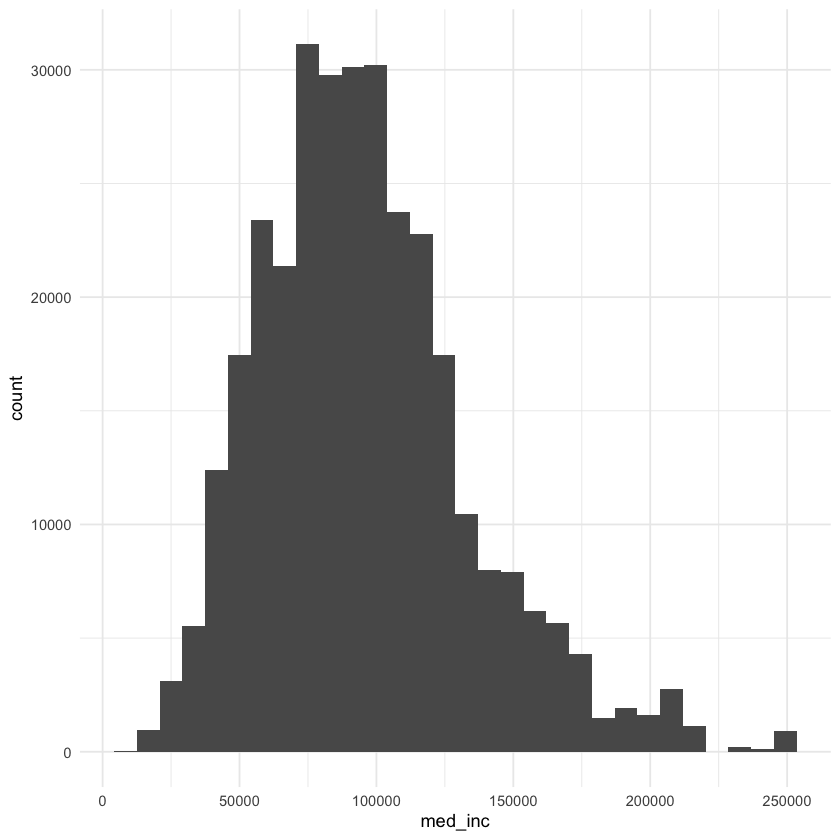

In [9]:
ggplot(census_merge) +
    geom_histogram(aes(x = med_inc)) +
    theme_minimal()

#### White Population Distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


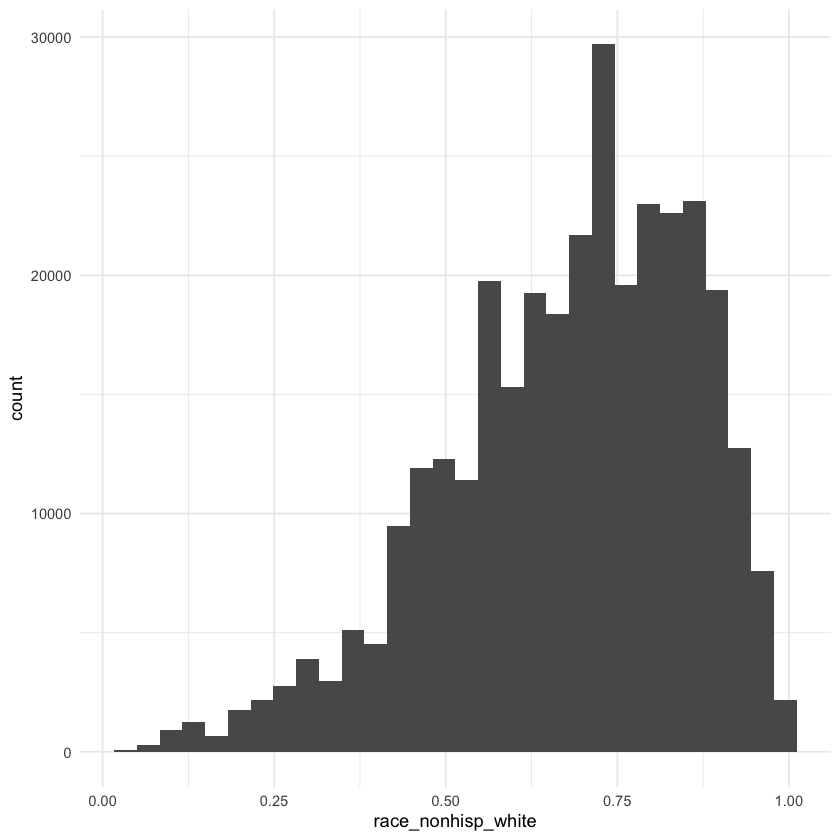

In [10]:
ggplot(census_merge) + 
    geom_histogram(aes(x = race_nonhisp_white)) +
    theme_minimal()

#### Age Distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


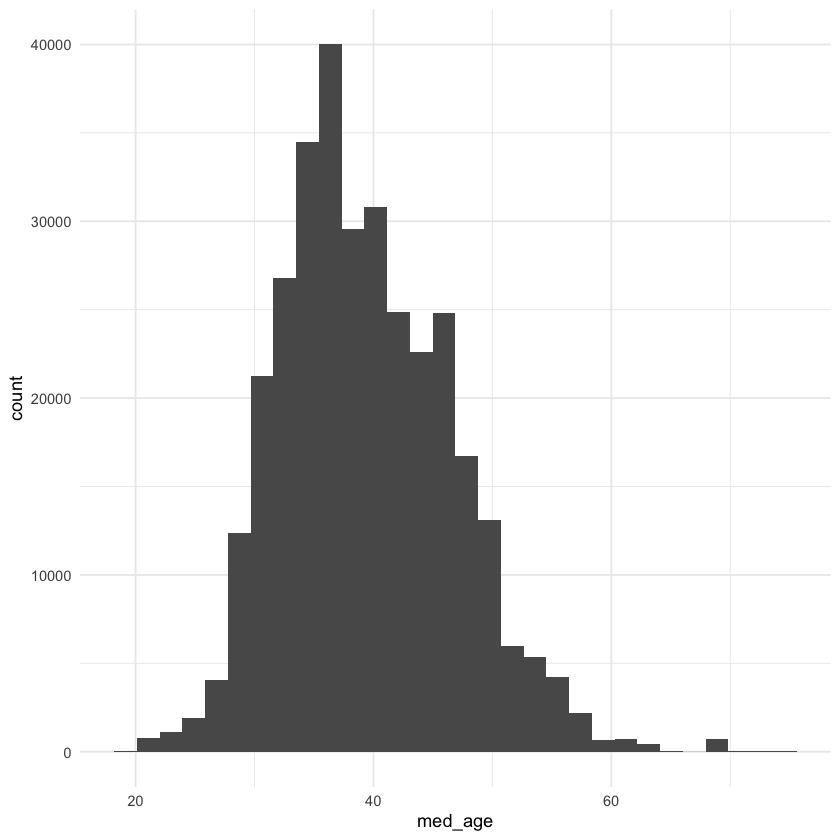

In [11]:
ggplot(census_merge) + 
    geom_histogram(aes(x = med_age)) +
    theme_minimal()

## Trips

In [12]:
trips = load_table(db_path, "trips")

##### Fares are largely skewed to .75 cents since it is the minimum toll

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


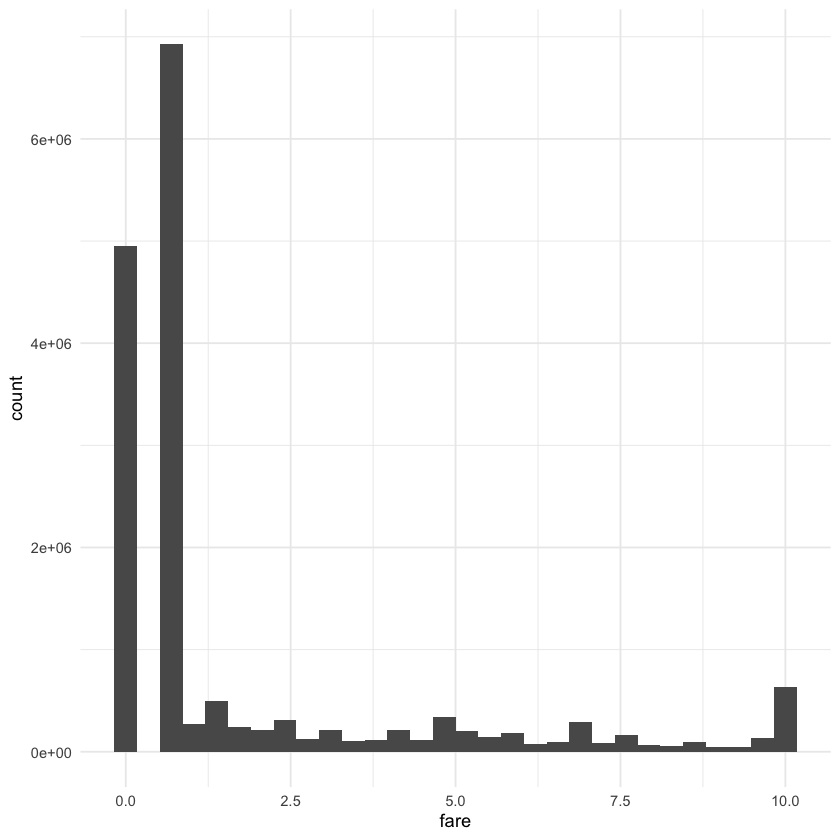

In [13]:
trip_fare = trips %>%
    select(fare) %>%
    execute

#plots count of trips by each fare price
ggplot(trip_fare) +
  geom_histogram(aes(x = fare)) +
    theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


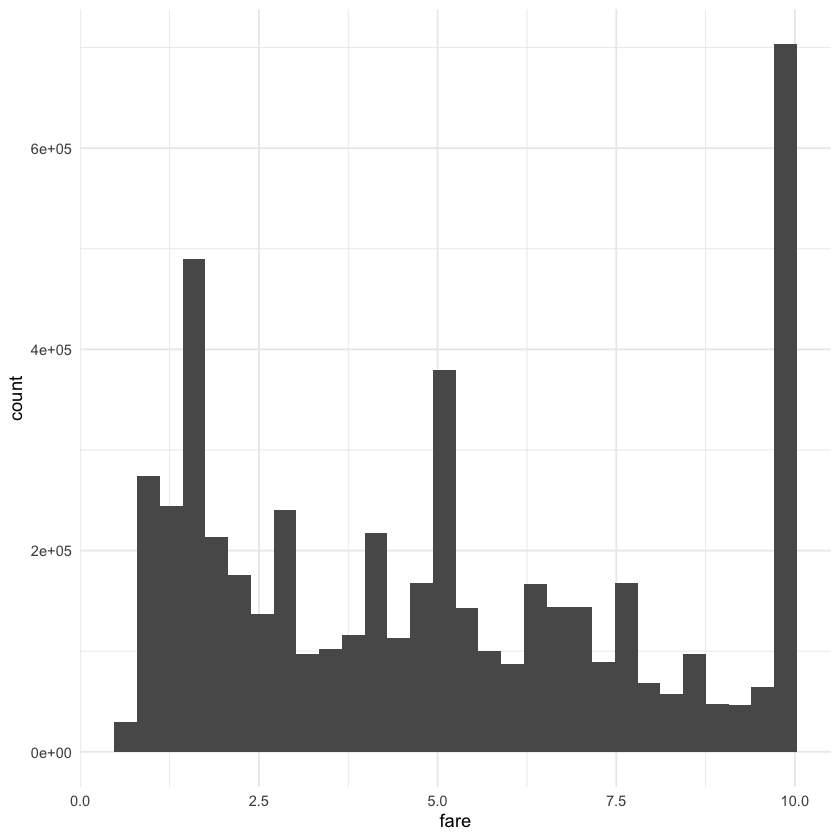

In [14]:
# trips with the non-minimum fare of .75
nonmin_trip_fare <- trip_fare %>%
    filter(fare > .75)

ggplot(nonmin_trip_fare) +
  geom_histogram(aes(x = fare)) +
    theme_minimal()

In [15]:
trip_entry_time = trips %>%
    select(entry_time) %>%
    execute

In [1]:
# converts several time to more specific measures for graphing
trip_entry_time$entry_time <- as_datetime(trip_entry_time$entry_time, tz = "UTC")
#trip_entry_time$time <- format(as.POSIXct(trip_entry_time$entry_time,format="%Y:%m:%d %H:%M:%S"),"%H:%M:%S")
#trip_entry_time$date <- format(as.POSIXct(trip_entry_time$entry_time,format="%Y:%m:%d %H:%M:%S"),"%Y:%m:%d")
trip_entry_time$hour <- format(as.POSIXct(trip_entry_time$entry_time,format="%Y:%m:%d %H:%M:%S"),"%H")
trip_entry_time$monthday <- format(as.POSIXct(trip_entry_time$entry_time,format="%Y:%m:%d %H:%M:%S"),"%m%d")

ERROR: Error in as_datetime(trip_entry_time$entry_time, tz = "UTC"): could not find function "as_datetime"


#### Count of Entries by Hour of Day

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

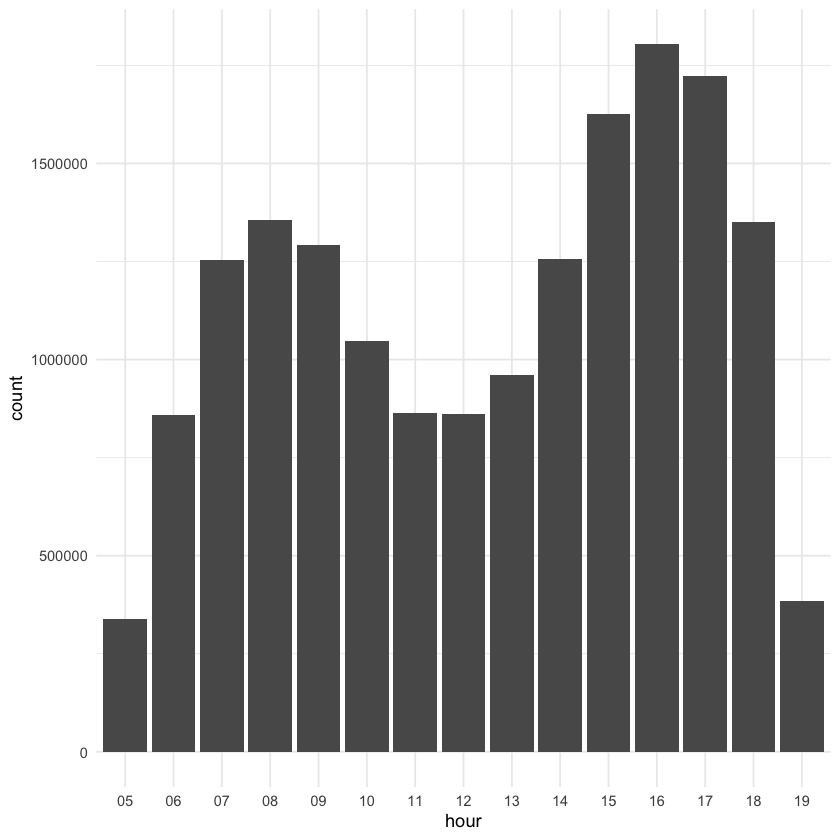

In [17]:
ggplot(trip_entry_time) +
    geom_histogram(aes(x = hour), stat = "count") +
    theme_minimal()

#### Count of Entries by Day and Month Over 2018

In [30]:
# creates table with the count of trips for each day
freq_table <- trip_entry_time %>%
    group_by(monthday) %>%
    summarize(sum = n()) 

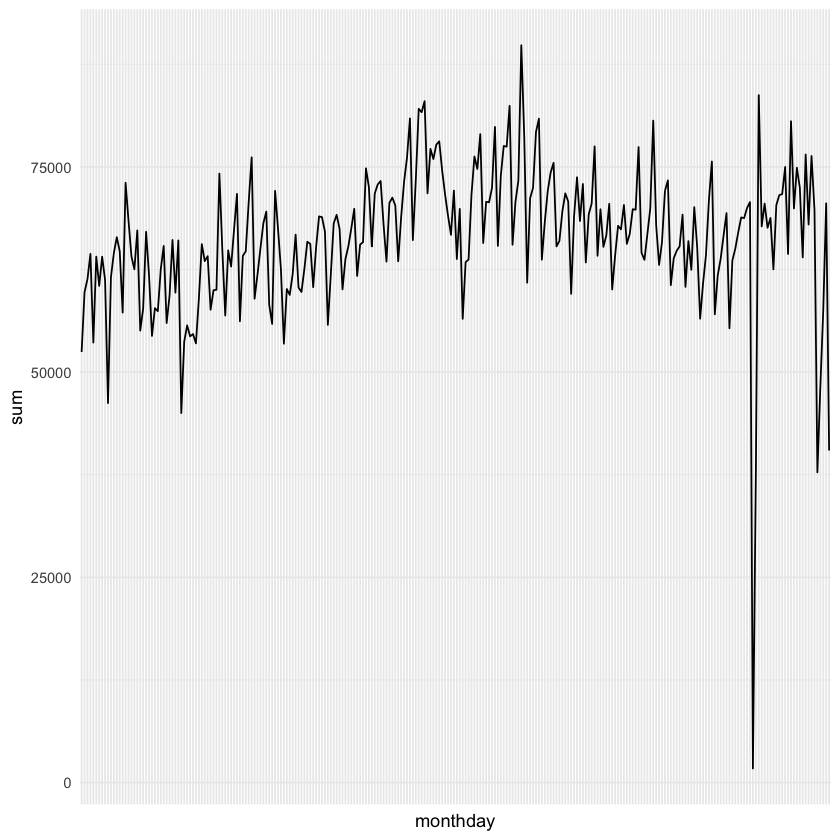

In [31]:
ggplot(freq_table, aes(x = monthday, y = sum, group = 1)) +
    geom_line() +
    theme_minimal() + 
    theme(axis.text.x=element_blank())

##### The lowest values are throughout Thanksgiving and Christmas, which is unsuprising. The facitily does not function on Christmas Day.

In [34]:
head(arrange(freq_table, sum),10)

monthday,sum
<chr>,<int>
1122,1722
1123,37149
1224,37790
1231,40449
0219,45014
0115,46230
1226,48098
0102,52449
0409,53459


## BOS

ERROR: Error in load_table(db_path, "trip_acs"): could not find function "load_table"
